# Model Tutorial: Graph classification with Transformers

In [2]:
%pip install -U datasets transformers
%pip install matplotlib
# %pip install transformers
# %pip install rdkit
# %pip install deepsmiles

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from datasets import load_dataset

# There is only one split on the hub
dataset = load_dataset("OGB/ogbg-molhiv")

dataset = dataset.shuffle(seed=0)

print(dataset)

/Users/yunyicheng/opt/anaconda3/envs/MF/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 32901
    })
    validation: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 4113
    })
    test: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 4113
    })
})


<class 'datasets.dataset_dict.DatasetDict'>
<class 'dict'>


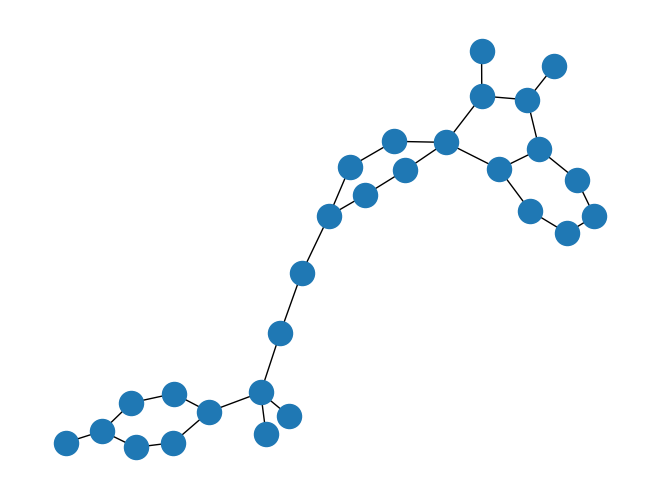

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# We want to plot the first train graph
graph = dataset["train"][0]
print(type(dataset))
edges = graph["edge_index"]
num_edges = len(edges[0])
num_nodes = graph["num_nodes"]

# Conversion to networkx format
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from([(edges[0][i], edges[1][i]) for i in range(num_edges)])

# Plot
nx.draw(G)

print(type(graph))

In [5]:
from transformers.models.graphormer.collating_graphormer import preprocess_item, GraphormerDataCollator

dataset_processed = dataset.map(preprocess_item, batched=False)
print(dataset_processed['validation'])

/Users/yunyicheng/opt/anaconda3/envs/MF/lib/python3.11/site-packages/setuptools/config/expand.py:134: SetuptoolsWarning: File '/Users/yunyicheng/Desktop/BCB430/transformers/src/transformers/models/massformer/README.md' cannot be found
  return '\n'.join(


Dataset({
    features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat', 'input_nodes', 'attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'out_degree', 'input_edges', 'labels'],
    num_rows: 4113
})


In [6]:
from transformers import GraphormerForGraphClassification

model = GraphormerForGraphClassification.from_pretrained(
    "clefourrier/pcqm4mv2_graphormer_base",
    num_classes=2, # num_classes for the downstream task 
    ignore_mismatched_sizes=True,
)
print(model)


Some weights of GraphormerForGraphClassification were not initialized from the model checkpoint at clefourrier/pcqm4mv2_graphormer_base and are newly initialized because the shapes did not match:
- classifier.classifier.weight: found shape torch.Size([1, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GraphormerForGraphClassification(
  (encoder): GraphormerModel(
    (graph_encoder): GraphormerGraphEncoder(
      (dropout_module): Dropout(p=0.0, inplace=False)
      (graph_node_feature): GraphormerGraphNodeFeature(
        (atom_encoder): Embedding(4609, 768, padding_idx=0)
        (in_degree_encoder): Embedding(512, 768, padding_idx=0)
        (out_degree_encoder): Embedding(512, 768, padding_idx=0)
        (graph_token): Embedding(1, 768)
      )
      (graph_attn_bias): GraphormerGraphAttnBias(
        (edge_encoder): Embedding(1537, 32, padding_idx=0)
        (edge_dis_encoder): Embedding(131072, 1)
        (spatial_pos_encoder): Embedding(512, 32, padding_idx=0)
        (graph_token_virtual_distance): Embedding(1, 32)
      )
      (emb_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x GraphormerGraphEncoderLayer(
          (dropout_module): Dropout(p=0.0, inplace=False)
          (activation_dropout_module): Dr

In [7]:
%pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.24.1
    Uninstalling accelerate-0.24.1:
      Successfully uninstalled accelerate-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [8]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    "graph-classification",
    logging_dir="graph-classification",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    auto_find_batch_size=True, # batch size can be changed automatically to prevent OOMs
    gradient_accumulation_steps=10,
    dataloader_num_workers=4, #1, 
    num_train_epochs=20,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_processed["train"],
    eval_dataset=dataset_processed["validation"],
    data_collator=GraphormerDataCollator(),
)


In [9]:
tgraph1 = dataset_processed['train'].select(list(range(0,1)))
preds = trainer.predict(tgraph1) # predict the first datapoint in training dataset
print(preds)

/Users/yunyicheng/opt/anaconda3/envs/MF/lib/python3.11/site-packages/setuptools/config/expand.py:134: SetuptoolsWarning: File '/Users/yunyicheng/Desktop/BCB430/transformers/src/transformers/models/massformer/README.md' cannot be found
  return '\n'.join(
/Users/yunyicheng/opt/anaconda3/envs/MF/lib/python3.11/site-packages/setuptools/config/expand.py:134: SetuptoolsWarning: File '/Users/yunyicheng/Desktop/BCB430/transformers/src/transformers/models/massformer/README.md' cannot be found
  return '\n'.join(
/Users/yunyicheng/opt/anaconda3/envs/MF/lib/python3.11/site-packages/setuptools/config/expand.py:134: SetuptoolsWarning: File '/Users/yunyicheng/Desktop/BCB430/transformers/src/transformers/models/massformer/README.md' cannot be found
  return '\n'.join(
/Users/yunyicheng/opt/anaconda3/envs/MF/lib/python3.11/site-packages/setuptools/config/expand.py:134: SetuptoolsWarning: File '/Users/yunyicheng/Desktop/BCB430/transformers/src/transformers/models/massformer/README.md' cannot be found


PredictionOutput(predictions=(array([[0.51332086, 0.56201696]], dtype=float32), [array([[[ 6.86479616e-04, -1.02547072e-02, -1.97185902e-04,
         -3.70436319e-04,  4.67725098e-04, -1.51660424e-04,
          6.24585664e-04,  6.79703444e-05, -1.85502321e-03,
         -5.54116443e-04, -2.54690945e-02,  2.80511379e-03,
         -2.25633266e-05,  1.37921568e-04,  1.91664323e-03,
          1.31840631e-01,  8.66144896e-04,  3.15165089e-04,
          2.56634637e-04,  3.26415971e-02, -3.33893957e-04,
          3.03010922e-04,  3.39893997e-03, -1.37587576e-05,
          5.02176583e-03, -2.53803313e-01,  5.05200820e-04,
         -3.34589306e-04, -3.43968335e-04, -1.00526516e-03,
         -1.66005641e-03,  2.73613168e-05, -3.41971841e-04,
         -1.82451941e-02,  1.53469238e-02, -6.53022900e-04,
          8.62624904e-04, -6.20540290e-04,  1.10476147e-02,
          2.07057878e-04, -2.18828311e-04, -5.68703574e-04,
          5.53309917e-04, -1.76595390e-01,  4.14374098e-03,
          7.2208570

In [10]:
# # Function to convert SMILES to Graphormer input format
# def preprocess_smiles(smiles):
#     # Use deepsmiles to convert SMILES to canonical SMILES
#     converter = deepsmiles.Converter(rings=True, branches=True)
#     canonical_smiles = converter.encode(smiles)

#     # Tokenize the canonical SMILES for Graphormer input
#     tokenizer = GraphormerTokenizer.from_pretrained("seyonec/graphormer-large-huc")
#     input_ids = tokenizer(canonical_smiles, return_tensors="pt").input_ids

#     return input_ids

# # Function to predict mass spectrum from SMILES
# def predict_mass_spectrum(smiles):
#     # Preprocess SMILES
#     input_ids = preprocess_smiles(smiles)

#     # Load pre-trained Graphormer model
#     model = GraphormerForConditionalGeneration.from_pretrained("seyonec/graphormer-large-huc")

#     # Make prediction
#     with torch.no_grad():
#         outputs = model.generate(input_ids, max_length=100, num_beams=5, length_penalty=0.6)

#     # Decode the predicted mass spectrum
#     mass_spectrum = tokenizer.decode(outputs[0], skip_special_tokens=True)

#     return mass_spectrum

# # Simple test
# smiles_example = "CC(=O)OC1=CC=CC=C1C(=O)O"
# predicted_spectrum = predict_mass_spectrum(smiles_example)

# print("SMILES:", smiles_example)
# print("Predicted Mass Spectrum:", predicted_spectrum)